In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob as gb
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , Conv2DTranspose , Dense , BatchNormalization , LeakyReLU , ReLU , Flatten, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
# from tensorflow.keras.losses.legacy_losses import gradient_penalty
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow_hub as hub
from tensorflow.dtypes import float16

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

In [ ]:
tf.test.is_gpu_available()

Inception score = 0.48


In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 128
BUFFER_SIZE = 1000
Z_DIM = 128
# DATASET_DIR = '/content/drive/MyDrive/datasets/lung_and_colon_cancer_datasets'

In [ ]:
classes = []
for folder in tqdm(os.listdir(DATASET_DIR)) :
    for path in os.listdir(DATASET_DIR + "/" + folder) :
        if path not in classes :
            classes.append(path)

In [ ]:
img_label={key : value for value , key in enumerate(classes)}
img_label

In [ ]:
def getlabel(n) :
    for x , y in img_label.items() :
        if y==n :
            return x

In [ ]:
img_paths = []
labels = []
for folder in tqdm(os.listdir(DATASET_DIR)) :
    for path in os.listdir(DATASET_DIR + "/" + folder) :
        files = gb.glob(pathname = str(DATASET_DIR + "/" + folder + "/" + path + "/*.jpeg"))
        for file in files :
            img_paths.append(file)
            labels.append(img_label[path])

In [ ]:
np.unique(labels)

In [ ]:
def map_fn(img_path , label) :
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE , IMG_SIZE))
    img = tf.cast(img , tf.float32) / 255.

    return img , label

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_paths , labels))
dataset = dataset.map(map_fn)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
print(f"the size of the dataloader {len(dataset)} batches of {BATCH_SIZE}")

In [ ]:
img_sample , label_sample= next(iter(dataset))
img_sample.shape, label_sample.shape

2. Vizualizating data

In [ ]:
Visualize a few images from the training set
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    img = img_sample[i].numpy()
    ax.imshow(img)
    ax.axis('off')
    ax.set(title = f"{getlabel(label_sample[i])}")

3. Build NN

In [ ]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [ ]:
# Unconditional Generator
# Noise vector --> Dense layers --> Reshape --> Upsampling layers (3) --> Tanh output --> Generated image

generator = keras.Sequential([
    Dense(8 * 8 * 512, use_bias=False, input_shape=(Z_DIM,)),
    LeakyReLU(),
    keras.layers.Reshape((8, 8, 512)),

    Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh', use_bias=False),
])

In [ ]:
# generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             4194304   
                                                                 
 batch_normalization (Batch  (None, 32768)             131072    
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)       2097152   
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 256)       1

In [ ]:
# Unconditional Discriminator
# Input Image --> Convolutional Layers (3) --> Flatten --> Dense Layers --> Output (Real/Fake Probability)

discriminator = Sequential([
    keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(64, kernel_size=4, strides=2, padding='same', use_bias=False),
    LeakyReLU(0.2),
    Dropout(0.4),

    Conv2D(128, kernel_size=4, strides=2, padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),
    Dropout(0.4),

    Conv2D(256, kernel_size=4, strides=2, padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),
    Dropout(0.4),

    Conv2D(512, kernel_size=4, strides=2, padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),
    Dropout(0.4),

    Flatten(),

    Dense(1, activation='sigmoid', use_bias=False)
])

In [ ]:
# discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        3072      
                                                                 
 batch_normalization_4 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       131072    
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)      

In [ ]:
# Load weights from the model trained for 500 epochs
#3
# generator.load_weights("/content/drive/MyDrive/DCGANmodels/Pruned/LungandColonCancerGeneratorPrunedModel.h5")
# discriminator.load_weights("/content/drive/MyDrive/DCGANmodels/Pruned/LungandColonCancerDiscriminatorPrunedModel.h5")

discriminator.load_weights("/content/drive/MyDrive/DCGANmodels/original600all/final600LungandColonCancerDiscriminator.h5")
generator.load_weights("/content/drive/MyDrive/DCGANmodels/original600all/final600LungandColonCancerGenerator.h5")

4. Construct Training Loop

In [ ]:
# gen_optimizer = Adam(learning_rate=0.0002, beta_1=0.5 , beta_2=0.999)
# disc_optimizer = RMSprop(learning_rate=0.0002)
# criterion = BinaryCrossentropy(from_logits=True)
gen_optimizer = Adam(learning_rate=0.0002 , beta_1=0.5 , beta_2=0.999)
disc_optimizer = Adam(learning_rate=0.0002 , beta_1=0.5 , beta_2=0.999)
criterion = BinaryCrossentropy(from_logits=True)
Epochs = 500

# Test image generated

In [ ]:
def generate_images(index) :
    noise = tf.random.normal([BATCH_SIZE , Z_DIM])
    preds = generator(noise , training = False)
    fig = plt.figure(figsize=(8, 8))
    for i in range(12):
        image = (preds[i, :, :, :] + 1.)/2.  # Rescale for visualization
        image = np.array(image)  # Convert to NumPy array for saving
        #filename = f"colonca_generated_image_{index}{i+1}.png"
        #plt.imsave(f"/content/drive/MyDrive/datasets/lung_and_colon_cancer_datasets/colon_generated_image_sets/colon_aca/{filename}", image)

        plt.subplot(4, 4, i+1)
        plt.imshow((preds[i, :, :, :]+1.)/2.)
        plt.axis('off')
    plt.show()

i??????????????????????????????????? 0


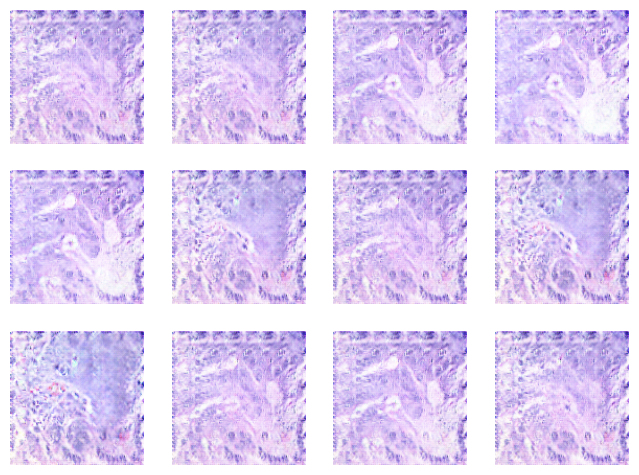

i??????????????????????????????????? 1


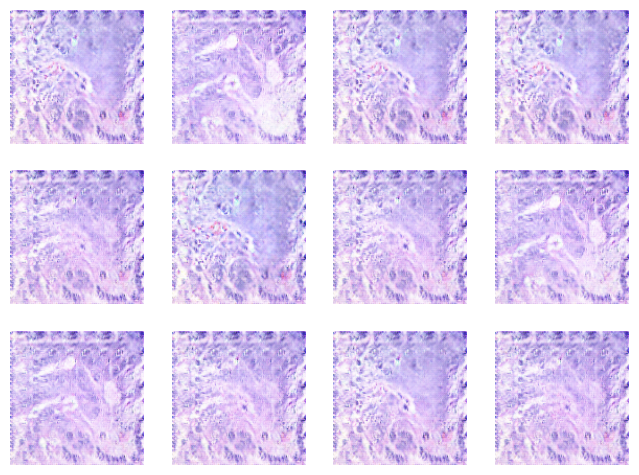

i??????????????????????????????????? 2


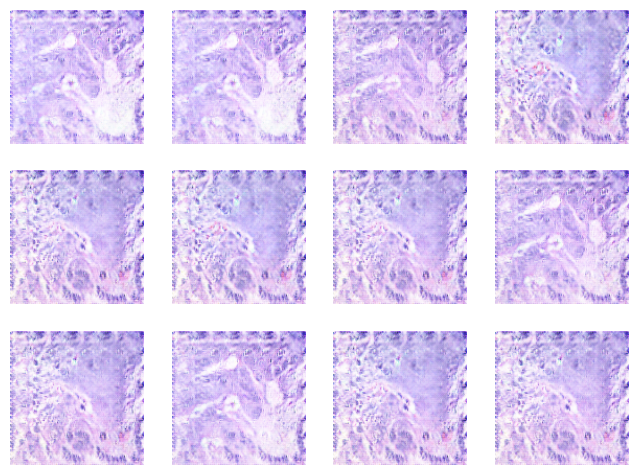

i??????????????????????????????????? 3


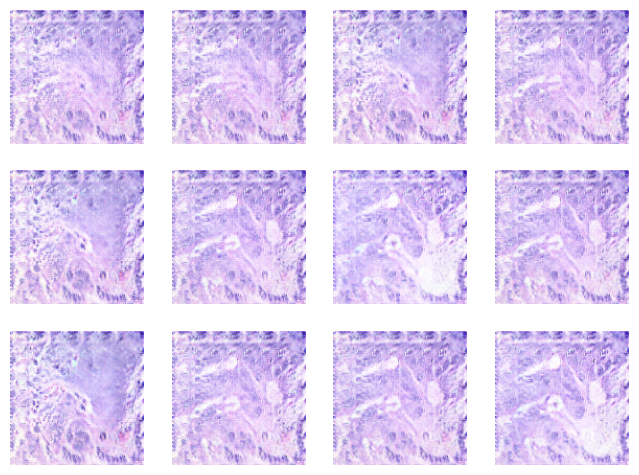

i??????????????????????????????????? 4


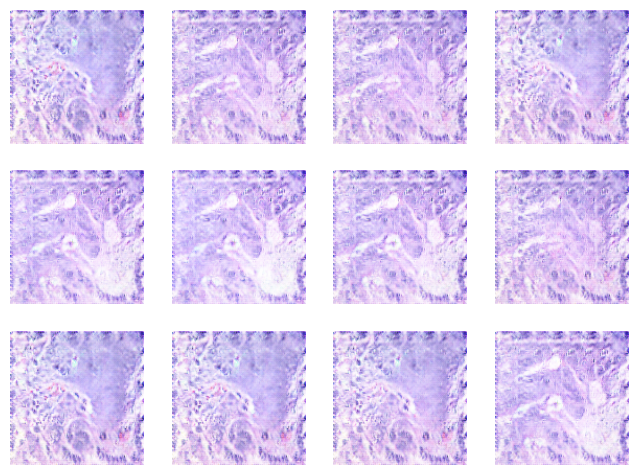

i??????????????????????????????????? 5


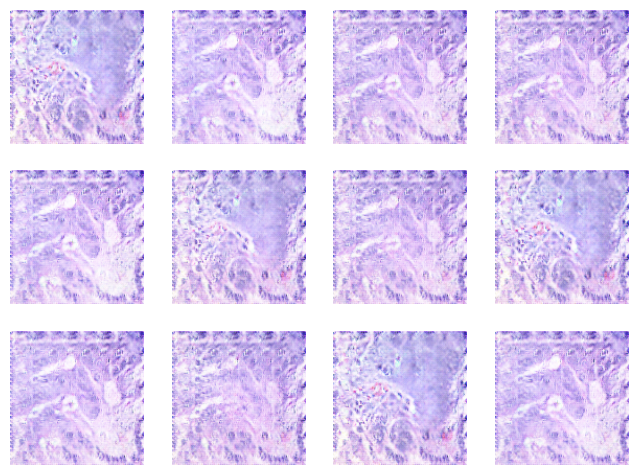

i??????????????????????????????????? 6


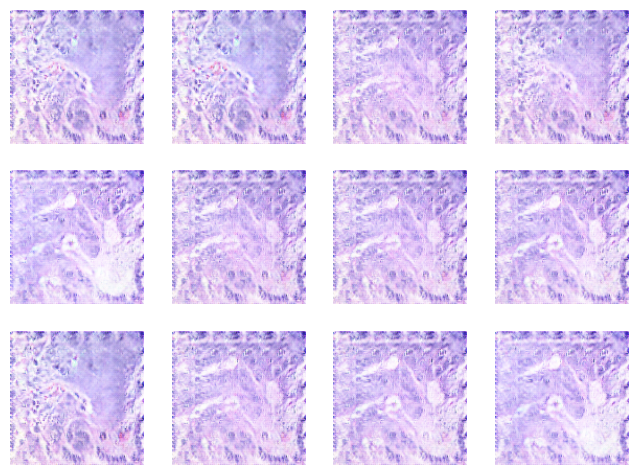

i??????????????????????????????????? 7


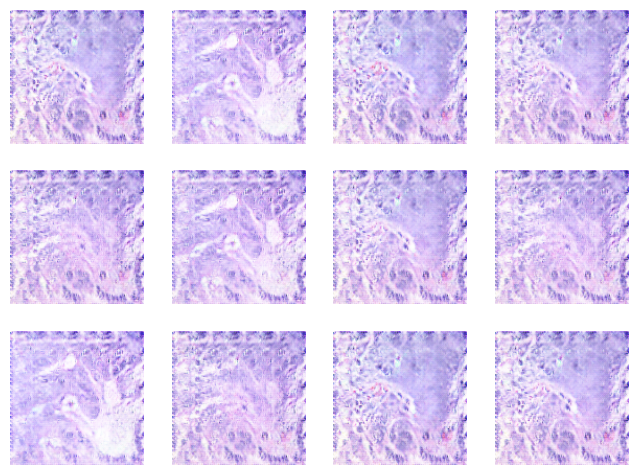

i??????????????????????????????????? 8


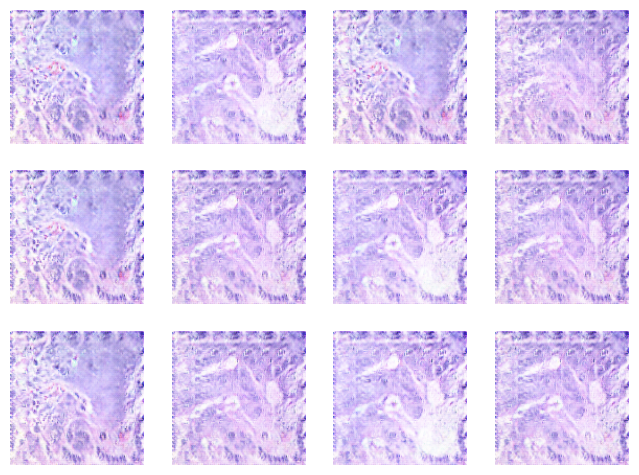

i??????????????????????????????????? 9


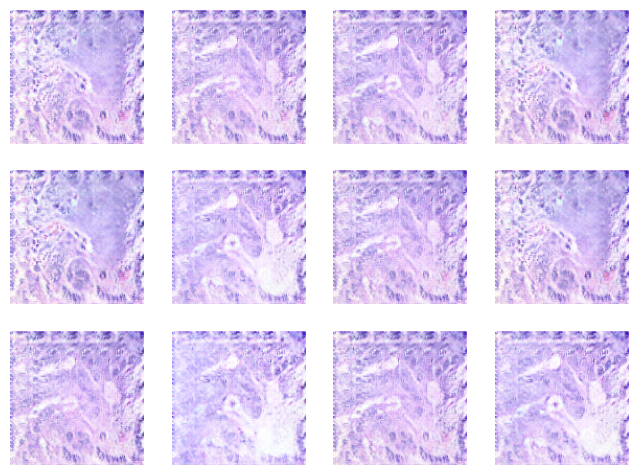

i??????????????????????????????????? 10


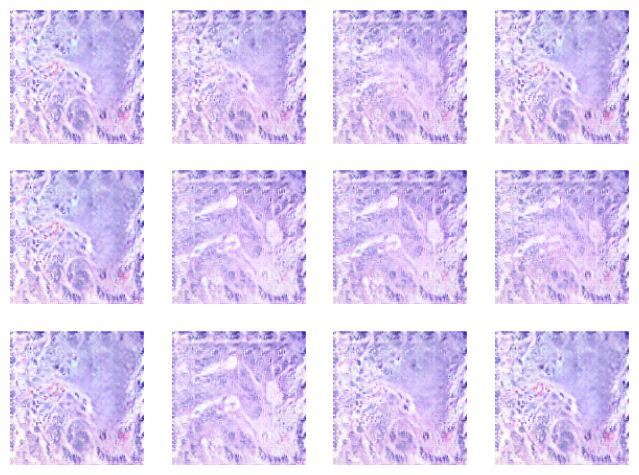

i??????????????????????????????????? 11


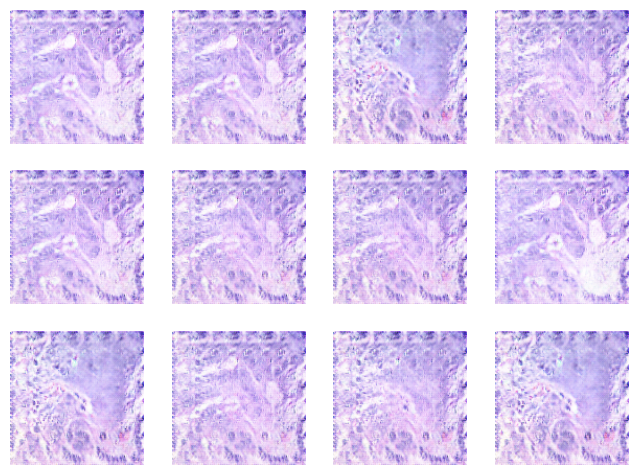

i??????????????????????????????????? 12


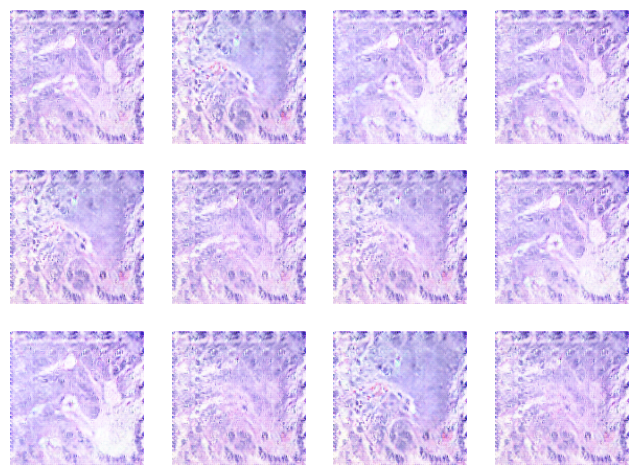

i??????????????????????????????????? 13


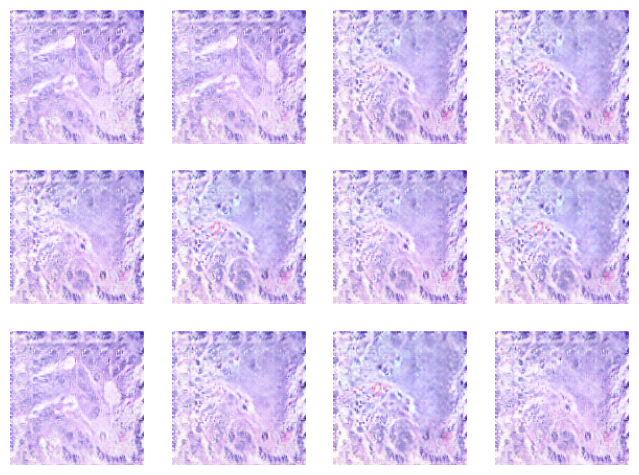

i??????????????????????????????????? 14


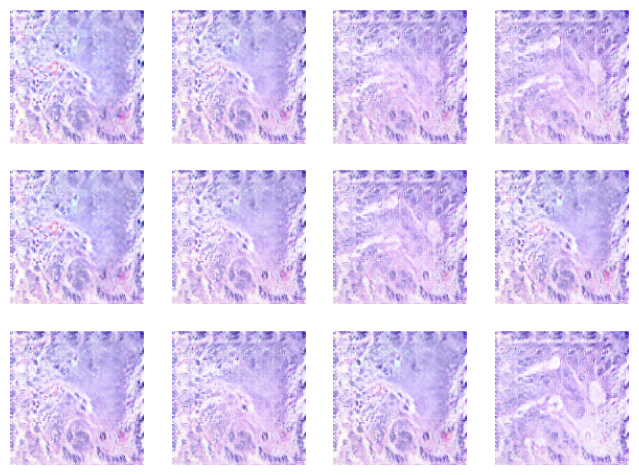

In [ ]:
# for i in range(15):
#   generate_images(i)

In [ ]:
def discriminator_loss(real_output , fake_output) :
    real_loss = criterion(tf.ones_like(real_output) , real_output)
    fake_loss = criterion(tf.zeros_like(fake_output) , fake_output)

    total_loss = real_loss + fake_loss

    return total_loss

def generator_loss(fake_output) :
    return criterion(tf.ones_like(fake_output) , fake_output)

In [ ]:
@tf.function
def train_step(images) :
    noise = tf.random.normal([BATCH_SIZE , Z_DIM])
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape :
        fake_images = generator(noise , training = True)

        real_output = discriminator(images , training = True)
        fake_output = discriminator(fake_images , training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output , fake_output)

    gen_gradients = gen_tape.gradient(gen_loss , generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss , discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients , generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients , discriminator.trainable_variables))

    return gen_loss , disc_loss

5. Test model

In [ ]:
with tf.device("/GPU:0") :
    disc_losses = []
    gen_losses = []
    for i in tqdm(range(600)) :
        epoch_disc_loss = []
        epoch_gen_loss = []
        for image , label in dataset :
            gen_loss , disc_loss = train_step(image)

            epoch_disc_loss.append(disc_loss)
            epoch_gen_loss.append(gen_loss)

        disc_losses.append(np.mean(epoch_disc_loss))
        gen_losses.append(np.mean(epoch_gen_loss))

        if (i+1) % 50 == 0 :
            print(f"Epoch : {i+1} ----> Generator Loss : {gen_losses[-1]} and Discriminator Loss : {disc_losses[-1]}\n")
            generate_images(i+1)

In [ ]:
plt.plot(disc_losses , label='Discriminator')
plt.plot(gen_losses , label='Generator')

plt.title('Discriminator/Generator loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

6. GAN performance measurement

In [ ]:
# pip install tensorflow-hub
# !pip install tensorflow_gan

In [ ]:
# inception_model = hub.load("https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4")
# noise = tf.random.normal([BATCH_SIZE , Z_DIM])

# # Generate a batch of images
# fake_images = generator(noise, training=False)

# # Preprocess images for Inception model
# fake_images = tf.image.resize(fake_images, (299, 299)) * 255.0
# fake_images = tf.cast(fake_images, tf.float32)

# # Calculate IS
# # inception_features = inception_model(fake_images)
# inception_features = inception_model(fake_images, batch_norm_momentum=0.99)
# is_score = tf.math.reduce_mean(tf.math.exp(tf.nn.log_softmax(inception_features)))
# print(f"Inception Score: {is_score.numpy()}")

In [ ]:
# from tensorflow_gan.eval.python import eval_utils
# from tensorflow.keras.applications import InceptionV3
# inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# # Generate a batch of images
# fake_images = generator(noise, training=False)

# # Calculate FID
# fid = eval_utils.frechet_inception_distance(
#     inception_model, real_images, fake_images, batch_size=50
# )  # Adjust batch_size as needed
# print(f"Fréchet Inception Distance: {fid}")

7. Saving the model

In [ ]:
generator.save('/content/drive/MyDrive/DCGANmodel/FinalLungColonCancerGenerator.h5')
discriminator.save('/content/drive/MyDrive/DCGANmodel/FinalLungColonCancerDiscriminator.h5')